Flower Classification Experiment

The dataset is curated by the Tensorflow Team and contains 5 classes of flowers: Roses, Tulips, Dandelions, Sunflowers, and Daisies.

This experiment wants to explore the usage of CNNs and Keras Tuner, specifically Hyperband.

In [27]:
'''
Description: https://www.tensorflow.org/datasets/catalog/tf_flowers
Download: http://download.tensorflow.org/example_images/flower_photos.tgz
'''

#Either uncomment the below line and execute it OR download it yourself.
#!wget http://download.tensorflow.org/example_images/flower_photos.tgz && tar -zxf flower_photos.tgz

--2020-07-08 16:19:55--  http://download.tensorflow.org/example_images/flower_photos.tgz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.13.128, 2a00:1450:400c:c03::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.13.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M  78.5MB/s    in 2.8s    

2020-07-08 16:19:58 (78.5 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [28]:
#Get Keras Tuner
!pip3 install keras-tuner

     |████████████████████████████████| 61kB 3.5MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=2a1a3679c7c4b508b23f949fafd6cbd5b0c85937857c75b7d63c77b87d626864
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=d9e8ab3266c1a03a68f7a178989fa263776a87ac2cdca2bc7ede6bbc2b1d526a
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
'''
Hyperband usage.
Goal: Use Hyperband to see which models can best perform flower
      classification.
'''

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
import kerastuner as kt
import os

#Obtain Data
dataGen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=0.5,
    validation_split=0.2)

IMG_SIZE=128

train = dataGen.flow_from_directory(
    './flower_photos',
    target_size=(IMG_SIZE,IMG_SIZE),
    subset='training')
val = dataGen.flow_from_directory(
    './flower_photos',
    target_size=(IMG_SIZE,IMG_SIZE),
    subset='validation')

def build_model(hp):
  dropout = 0.5
  convParams = [
                (
                hp.Int('convFiltersSize'+str(i),32,64),
                3
                )
                for i in range(0,hp.Int('convLayerCount',1,3))
              ]
  maxPoolParams = 2
  convFunc = 'relu'

  annParams = [
                hp.Int('annLayerSize'+str(i),32,64)
                for i in range(0,hp.Int('annLayerCount',1,3))
              ]

  annFunc = 'relu'

  cnnLayers = []
  for (filter,kernel) in convParams:
    cnnLayers += [layers.Conv2D(filter,(kernel,kernel),activation=convFunc)]
    cnnLayers += [layers.MaxPooling2D((maxPoolParams,maxPoolParams))]
    cnnLayers += [layers.Dropout(dropout)]

  annLayers = []
  for ls in annParams:
    annLayers += [layers.Dense(ls,activation=annFunc)]
    annLayers += [layers.Dropout(dropout)]
  annLayers += [layers.Dense(5,activation='softmax')]

  allLayers = cnnLayers+[layers.Flatten()]+annLayers

  model = Sequential(allLayers)
  model.compile(optimizer=Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

  return model
  


tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=11,
    factor=3,
    directory='Flower',
    project_name='Factor3Epoch11'
)

tuner.search(
    train,
    validation_data = val
)


Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.
INFO:tensorflow:Reloading Oracle from existing project Flower/Factor3Epoch11/oracle.json
INFO:tensorflow:Reloading Tuner from Flower/Factor3Epoch11/tuner0.json
INFO:tensorflow:Oracle triggered exit


ValueError: ignored

In [ ]:
'''
Training the 5 best models from Hyperband
Goal: Hyperband has found a few models that are worth looking into.
      Train these models further to see which one is worth training.
'''

i = 0
data = []
for m in tuner.get_best_models(num_models=5):
  i+=1
  data.append(m.fit(
    train,
    validation_data = val,
    epochs=50))
  tf.keras.models.save_model(m,'./tunerbestmodels_e50_'+str(i))

Epoch 1/50
92/92 [==============================] - 28s 304ms/step - loss: 1.4213 - accuracy: 0.4753 - val_loss: 1.3846 - val_accuracy: 0.5048
Epoch 2/50
92/92 [==============================] - 27s 298ms/step - loss: 1.4171 - accuracy: 0.4767 - val_loss: 1.3797 - val_accuracy: 0.5185
Epoch 3/50
92/92 [==============================] - 27s 298ms/step - loss: 1.4027 - accuracy: 0.4900 - val_loss: 1.3608 - val_accuracy: 0.5376
Epoch 4/50
92/92 [==============================] - 28s 300ms/step - loss: 1.4027 - accuracy: 0.4968 - val_loss: 1.3639 - val_accuracy: 0.5390
Epoch 5/50
92/92 [==============================] - 27s 299ms/step - loss: 1.3976 - accuracy: 0.4985 - val_loss: 1.3699 - val_accuracy: 0.5308
Epoch 6/50
92/92 [==============================] - 27s 297ms/step - loss: 1.4024 - accuracy: 0.4893 - val_loss: 1.3560 - val_accuracy: 0.5486
Epoch 7/50
92/92 [==============================] - 28s 301ms/step - loss: 1.4012 - accuracy: 0.4903 - val_loss: 1.3586 - val_accuracy: 0.5417

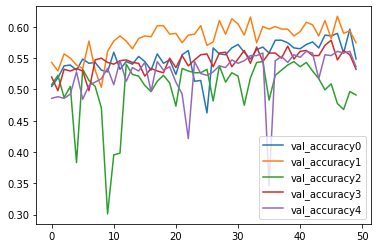

In [ ]:
'''
Data Plotting for the first round
Goal: Find which models are best based on validation metrics.
'''

import pandas as pd


df = pd.DataFrame()

for i in range(0,5):
  #df[['accuracy'+str(i)]] = pd.DataFrame(data[i].history)[['accuracy']]
  #df[['loss'+str(i)]] = pd.DataFrame(data[i].history)[['loss']]
  df[['val_accuracy'+str(i)]] = pd.DataFrame(data[i].history)[['val_accuracy']]
  #df[['val_loss'+str(i)]] = pd.DataFrame(data[i].history)[['val_loss']]


df.plot()

In [ ]:
'''
Data Training for second rounds of training
Goal: Train models that are best out of the 5 best models
      from Hyperband.
'''

i=0
data2 = []
for m in [
          tf.keras.models.load_model('./tunerbestmodels_e50_1'),
          tf.keras.models.load_model('./tunerbestmodels_e50_2'),
          tf.keras.models.load_model('./tunerbestmodels_e50_5'),
          ]:
  i+=1
  data2.append(m.fit(
    train,
    validation_data = val,
    epochs=50))
  tf.keras.models.save_model(m,'./tunerbestmodels_e100_'+str(i))

Epoch 1/50
92/92 [==============================] - 26s 281ms/step - loss: 1.3380 - accuracy: 0.5635 - val_loss: 1.3294 - val_accuracy: 0.5718
Epoch 2/50
92/92 [==============================] - 25s 276ms/step - loss: 1.3473 - accuracy: 0.5529 - val_loss: 1.3235 - val_accuracy: 0.5787
Epoch 3/50
92/92 [==============================] - 25s 277ms/step - loss: 1.3332 - accuracy: 0.5669 - val_loss: 1.3133 - val_accuracy: 0.5923
Epoch 4/50
92/92 [==============================] - 26s 278ms/step - loss: 1.3381 - accuracy: 0.5614 - val_loss: 1.3314 - val_accuracy: 0.5718
Epoch 5/50
92/92 [==============================] - 26s 277ms/step - loss: 1.3404 - accuracy: 0.5611 - val_loss: 1.3389 - val_accuracy: 0.5595
Epoch 6/50
92/92 [==============================] - 25s 276ms/step - loss: 1.3285 - accuracy: 0.5689 - val_loss: 1.3301 - val_accuracy: 0.5677
Epoch 7/50
92/92 [==============================] - 25s 276ms/step - loss: 1.3565 - accuracy: 0.5413 - val_loss: 1.3098 - val_accuracy: 0.5910

In [ ]:
'''
Data Plotting for the second round
Goal: Find which model is best based on validation metrics.
'''

import pandas as pd


df2 = pd.DataFrame()

for i in range(0,3):
  df2[['accuracy'+str(i)]] = pd.DataFrame(data2[i].history)[['accuracy']]
  df2[['loss'+str(i)]] = pd.DataFrame(data2[i].history)[['loss']]
  df2[['val_accuracy'+str(i)]] = pd.DataFrame(data2[i].history)[['val_accuracy']]
  df2[['val_loss'+str(i)]] = pd.DataFrame(data2[i].history)[['val_loss']]


df2.to_csv("Data2.csv")

In [ ]:
'''
Training what I deem is the "best model" based on 
validation loss and validation accuracy
'''

m=tf.keras.models.load_model('./tunerbestmodels_e100_2')

history = m.fit(
    train,
    validation_data = val,
    epochs=100)
tf.keras.models.save_model(m,'./tunerbestmodels_e250_1')

Epoch 1/100
92/92 [==============================] - 25s 276ms/step - loss: 1.2890 - accuracy: 0.6131 - val_loss: 1.2958 - val_accuracy: 0.6060
Epoch 2/100
92/92 [==============================] - 25s 275ms/step - loss: 1.2831 - accuracy: 0.6182 - val_loss: 1.2726 - val_accuracy: 0.6279
Epoch 3/100
92/92 [==============================] - 25s 274ms/step - loss: 1.2763 - accuracy: 0.6237 - val_loss: 1.2852 - val_accuracy: 0.6197
Epoch 4/100
92/92 [==============================] - 25s 275ms/step - loss: 1.2862 - accuracy: 0.6145 - val_loss: 1.2672 - val_accuracy: 0.6347
Epoch 5/100
92/92 [==============================] - 25s 275ms/step - loss: 1.3087 - accuracy: 0.5914 - val_loss: 1.2861 - val_accuracy: 0.6252
Epoch 6/100
92/92 [==============================] - 25s 273ms/step - loss: 1.2966 - accuracy: 0.6053 - val_loss: 1.3098 - val_accuracy: 0.5937
Epoch 7/100
92/92 [==============================] - 25s 274ms/step - loss: 1.2972 - accuracy: 0.6036 - val_loss: 1.2899 - val_accuracy:

In [71]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

'''
Here, I do a somewhat informal test by downloading pictures
and putting them through the model.

Some observations:

-Daisy identification looks fine?
-Dandelions are confused for sunflowers?
-The model seems to confuse roses for tulips and vice-versa?
-Sunflower identification seems okay?

Softmaxing may not be a good idea in hindsight as the loss of probability 
information making seeing uncertainty impossible.
'''



'''
Class Indices
{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}
'''

flower = image.load_img('/content/tulip2.jpg',target_size=(128,128))
flower = image.img_to_array(flower)
flower = np.expand_dims(flower,axis=0)
m=tf.keras.models.load_model('/content/tunerbestmodels_e250_1')

print(m.predict(flower))

[[0. 0. 0. 0. 1.]]


"\nClass Indices\n{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}\n"

For next time, CNN model design could use more work.

The "post-Hyperband rounds of training" data are contained in CSV files and the best model is included.